<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Helper-Functions" data-toc-modified-id="Helper-Functions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Helper Functions</a></span></li><li><span><a href="#Project-Narrative" data-toc-modified-id="Project-Narrative-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Project Narrative</a></span><ul class="toc-item"><li><span><a href="#Start-with-a-graph" data-toc-modified-id="Start-with-a-graph-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Start with a graph</a></span></li><li><span><a href="#Observe-cascades" data-toc-modified-id="Observe-cascades-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Observe cascades</a></span></li><li><span><a href="#Uncover-hidden-transmission-weights" data-toc-modified-id="Uncover-hidden-transmission-weights-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Uncover hidden transmission weights</a></span></li></ul></li></ul></div>

In [491]:
import matplotlib.pyplot as plt
import matplotlib.animation
import networkx as nx
import numpy as np
import edward as ed
from edward.models import Exponential
import tensorflow as tf
import time

In [492]:
sess = ed.get_session()

# Helper Functions

In [493]:
def build_cascade(time, seed, T):
    # Store number of nodes
    n = time.shape[0]

    # Transpose times and reduce minimum
    times_T = tf.minimum(tf.transpose(time),T)

    # Initialize transmission times to be max time except for seed node
    transmission = tf.ones(n)*T
    transmission = tf.subtract(transmission,tf.one_hot(seed, n)*T)

    
    # Continually update transmissions
    for _ in range(n):

        # Tile transmission
        transmission_tiled = tf.reshape(tf.tile(transmission,[n]),[n,n])

        # Add transposed times and tiled transmissions
        potential_transmission = tf.add(transmission_tiled,times_T)

        # Find minimum path from all new 
        potential_transmission_row = tf.reduce_min(potential_transmission, reduction_indices=[1])

        # Concatenate previous transmission and potential new transmission
        potential_transmission_stack = tf.stack([transmission,potential_transmission_row],axis=0)

        # Take the minimum of the original transmission and the potential new transmission
        transmission = tf.reduce_min(potential_transmission_stack, reduction_indices=[0])

    return transmission

In [495]:
def printCascade(cascade, T):
    print("node\t time")
    print("----\t ----")
    
    cascade_order = cascade.argsort().tolist()
    i=0
    
    while cascade[cascade_order[i]]<T:
        print('{:4d}\t {:0.2f}'.format(cascade_order[i], cascade[cascade_order[i]]))
        i+=1

In [496]:
def buildGraph(alpha):
    graph = nx.from_numpy_matrix(alpha)
    layout = nx.spring_layout(graph)
    weights = [graph[u][v]['weight']*5/alpha.max() for u,v in graph.edges()]
    labels = {node: str(node) for node in graph.nodes()}
    
    return graph, layout, weights, labels

In [497]:
def drawEmptyGraph(graph, layout, labels):   
    nx.draw(graph, layout, edges=graph.edges, labels=labels,  font_color="white")

In [498]:
def drawWeightedGraph(graph, layout, weights, labels):   
    nx.draw(graph, layout, edges=graph.edges, width=weights,labels=labels,  font_color="white")

In [499]:
def sampleCascade(alpha, T):
    alpha_tf = tf.convert_to_tensor(alpha, dtype=tf.float32)
    tau = Exponential(alpha_tf)
    cascade = sess.run(build_cascade(tau, 0, 10))
    cascade_order = cascade.argsort().tolist()
    
    return cascade

In [516]:
def drawNetworkProp(graph, layout, labels, cascade, T):
    cascade_order = cascade.argsort().tolist()

    fig, ax = plt.subplots(figsize=(8,7))
    
    for num in range(len(graph.nodes)):
        if cascade[cascade_order[num]] == T: break
        time.sleep(1)
        
        # Draw edges
        nx.draw_networkx_edges(graph,layout,width=1.0,alpha=0.5, labels=True, ax=ax)

        # Draw infected nodes
        inf=nx.draw_networkx_nodes(nx_graph,
                                   layout,
                                   node_color = 'r',
                                   nodelist=cascade_order[:num+1],
                                   alpha=1,
                                   ax=ax)

        # Draw uninfected nodes
        uninf=nx.draw_networkx_nodes(nx_graph,
                                     layout,
                                     edge_color = 'b',
                                     node_color = 'w',
                                     nodelist=cascade_order[num+1:],
                                     alpha=1,
                                     ax=ax)
        try:
            uninf.set_edgecolor("black")
        except:
            None

        # Draw node 
        nx.draw_networkx_labels(nx_graph,
                                layout,
                                labels=labels,  font_color="white", ax=ax)

        # Scale plot ax
        ax.set_xticks([])
        ax.set_yticks([])

        # Redraw cascade
        display.clear_output(wait=True)
        display.display(fig)

    display.clear_output(wait=True)
    return printCascade(cascade, T)

# Project Narrative

In [517]:
nx_graph, nx_layout, nx_weights, nx_labels = buildGraph(alpha)

In [522]:
alpha = np.array([[0, .1, 0, 0, 0, .2, 0, 0, 0, 0],
                  [0, 0, .5, 0, 0, 0, 0, .25, 0, 0],
                  [0, 0, 0, .4, 0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, .5, 0, 0, .1, 0, 0],
                  [0, 0, 0, 0, 0, .3, 0, 0, .2, 0],
                  [0, 0, 0, 0, 0, 0, .7, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0, 0, .6, 0],
                  [0, 0, 0, 0, 0, 0, 0, 0, 0, .3],
                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=np.float32)

alpha_tf = tf.convert_to_tensor(alpha, dtype=tf.float32)

tau = Exponential(alpha)

## Start with a graph

We start the problem with a network of nodes and edges. Where we don't observe a semi-connected graph, assume the graph is fully connected

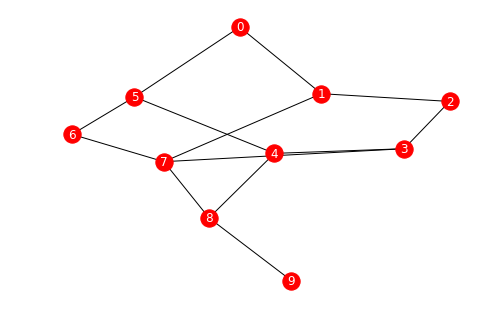

In [523]:
drawEmptyGraph(nx_graph, nx_layout, nx_labels)

## Observe cascades

We observe a series of infections that propagate throughout the network over time.

In [524]:
nx_cascade = drawCascade(alpha, 10)

node	 time
----	 ----
   0	 0.00
   5	 7.86
   6	 7.96
   7	 8.19
   8	 8.97


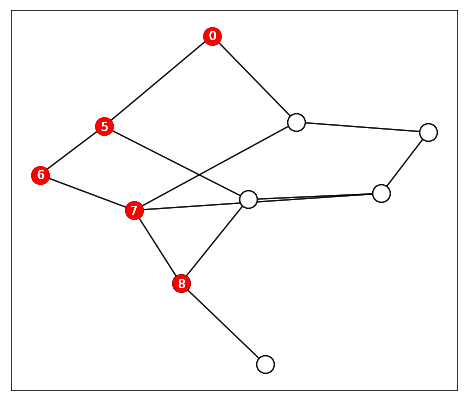

In [525]:
drawNetworkProp(nx_graph, nx_layout, nx_labels, nx_cascade, 10)

## Uncover hidden transmission weights

The goal is to infer the underlying transmission weights that show the propensity to become infected by its parent given the parent is infected

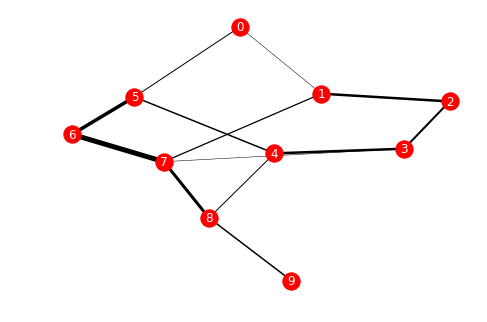

In [526]:
drawWeightedGraph(nx_graph, nx_layout, nx_weights, nx_labels)